In [47]:
%pip install -r requirements.txt -q

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!mkdir dataset
!curl -L -o dataset/micro_gas_turbine_electrical_energy_prediction.zip https://archive.ics.uci.edu/static/public/994/micro+gas+turbine+electrical+energy+prediction.zip

A subdirectory or file dataset already exists.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 20405    0 20405    0     0  20986      0 --:--:-- --:--:-- --:--:-- 21057
100  163k    0  163k    0     0  86308      0 --:--:--  0:00:01 --:--:-- 86437
100  715k    0  715k    0     0   238k      0 --:--:--  0:00:03 --:--:--  238k
100  887k    0  887k    0     0   246k      0 --:--:--  0:00:03 --:--:--  246k


In [4]:
import pandas as pd
import math
import glob
import matplotlib.pyplot as plt
import zipfile

In [5]:
zipfile.ZipFile('dataset/micro_gas_turbine_electrical_energy_prediction.zip').extractall('dataset/')
zipfile.ZipFile('dataset/test.zip').extractall('dataset/')
zipfile.ZipFile('dataset/train.zip').extractall('dataset/')

In [6]:
path_test = glob.glob('dataset/test/*.csv')
path_train = glob.glob('dataset/train/*.csv')

In [7]:
# Juntar todos os arquivos de treino em um único DataFrame
df_train = pd.concat([pd.read_csv(f) for f in path_train], ignore_index=True)
df_test = pd.concat([pd.read_csv(f) for f in path_test], ignore_index=True) 
len(df_train), len(df_test)

(52940, 18285)

In [8]:
df_train.head()

,time,input_voltage,el_power
0,810.07028,10.0,1228.791720
1,811.06938,10.0,1223.041745
2,812.06848,10.0,1244.960866
3,813.06758,10.0,1229.259058
4,814.06668,10.0,1248.117024


In [9]:
# Verificar o tempo de cada medição
df_train['time'].min(), df_train['time'].max(), (df_train['time'].max() - df_train['time'].min()) / 3600

(np.float64(810.0), np.float64(12636.84), np.float64(3.2852333333333332))

In [10]:
df_test['time'].min(), df_test['time'].max(), (df_test['time'].max() - df_test['time'].min()) / 3600

(np.float64(758.425813187233),
 np.float64(10545.5323989833),
 np.float64(2.7186407182766854))

In [11]:
df_test.head()

,time,input_voltage,el_power
0,880.3,3.0,1193.140713
1,881.3,3.0,1107.066421
2,882.3,3.0,1180.406767
3,883.3,3.0,1095.551498
4,884.3,3.0,1177.073719


In [12]:
colunas = df_train.columns

In [13]:
column_used = colunas[-1]  # Target column
column_used

'el_power'

# Funções utilizadas e base para a análise temporária

In [14]:
x_train = df_train[colunas[0]]
y_train = df_train[column_used]

x_test = df_test[colunas[0]]
y_test = df_test[column_used]

In [15]:
def calculo_b1_b0(column_x,column_y):
    x_mean = column_x.sum() / len(column_x)
    y_mean = column_y.sum() / len(column_y)
    
    numerador = 0
    denominador = 0
    
    for i in range(len(column_x)):
        numerador += (column_x[i] - x_mean) * (column_y[i] - y_mean)
        denominador += (column_x[i] - x_mean) ** 2
    
    b1 = numerador / denominador
    
    b0 = y_mean - (x_mean*b1)
    
    return b1,b0

b1,b0 = calculo_b1_b0(x_train,y_train)
b1,b0

(np.float64(0.056726897947851566), np.float64(1525.2797606834586))

In [16]:
def calculo_pred(b1,b0,x):
    return (b1 * x) + b0

In [17]:
def pred_test(column_x_test):
    column_y_pred = []
    
    for x in column_x_test:
        column_y_pred.append(calculo_pred(b1,b0,x))
    
    return column_y_pred
column_y_pred = pred_test(x_test)

In [18]:
def rmse(column_y_real,column_y_pred):
    n = len(column_y_real)
    numerador = 0.0
    
    for i in range(n):
        numerador += (column_y_real[i] - column_y_pred[i]) ** 2
    
    result = numerador / n
    
    return math.sqrt(result)

rmse(y_test,column_y_pred)

765.7460874262545

In [19]:
def mse(column_y_real,column_y_pred):
    n = len(column_y_real)
    numerador = 0.0
    
    for i in range(n):
        numerador += (column_y_real[i] - column_y_pred[i]) ** 2
    
    result = numerador / n
    
    return result

mse(y_test,column_y_pred)

np.float64(586367.0704086169)

# Validação real

In [20]:
best_column = ''
best_rmse = float('inf')
results = []

for column in colunas:
    if column == column_used:
        continue

    if df_train[column].dtype in ['float64', 'int64']:
        
        x_train = df_train[column]
        x_test = df_test[column]

        y_train = df_train[column_used]
        y_test = df_test[column_used]
        
        b1,b0 = calculo_b1_b0(x_train,y_train)
        column_y_pred = pred_test(x_test)
        
        rmse_value = rmse(y_test,column_y_pred)
        mse_value = mse(y_test,column_y_pred)
        
        if rmse_value < best_rmse:
            best_rmse = rmse_value
            best_column = column
        
        results.append((column, b1, b0, rmse_value, mse_value))
    else:
        print(f"Pulando coluna categórica: {column}")

print(f"Melhor coluna: {best_column} com RMSE: {best_rmse}")

Melhor coluna: input_voltage com RMSE: 382.6748888289727


In [21]:
df = pd.DataFrame(results, columns=['Column', 'b1', 'b0', 'RMSE', 'MSE']).sort_values(by='RMSE').reset_index(drop=True)
df

,Column,b1,b0,RMSE,MSE
0,input_voltage,250.184413,465.917254,382.674889,146440.070540
1,time,0.056727,1525.279761,765.746087,586367.070409


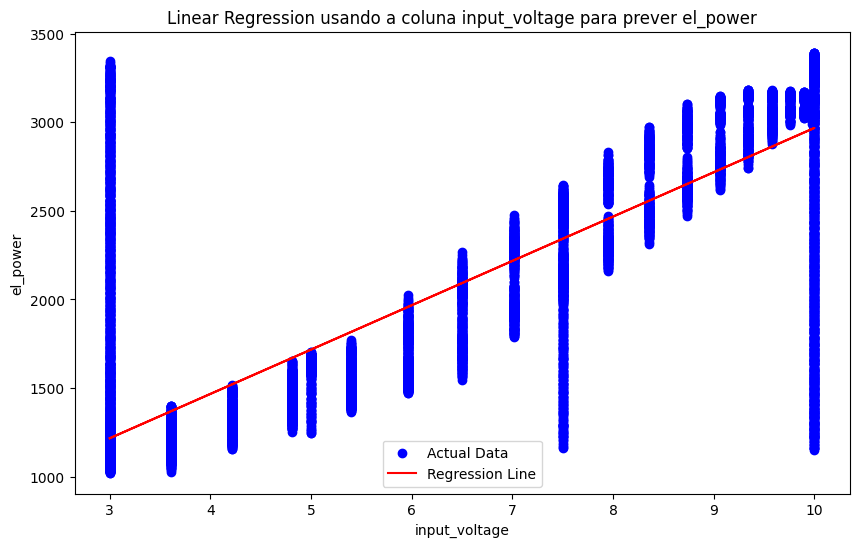

In [22]:
plt.figure(figsize=(10,6))
plt.scatter(x_test, y_test, color='blue', label='Actual Data')
plt.plot(x_test, column_y_pred, color='red', label='Regression Line')
plt.xlabel(best_column)
plt.ylabel(column_used)
plt.title(f'Linear Regression usando a coluna {best_column} para prever {column_used}')
plt.legend()

# Regressão multiplas

## Formulas

### Regressão Linear multipla

Função geral da regressão linear múltipla:
Y = β0 + β1X1 + β2X2 + ... + βnXn + ε

#### Descrição dos termos:
- Y: Variável dependente (o que estamos tentando prever)
- X1, X2, ..., Xn: Variáveis independentes (os preditores)
- β0: Essa variavel é o intercepto, ou seja, o valor de Y quando todas as variáveis independentes são iguais a zero.
- β1, β2, ..., βn: Coeficientes de regressão que representam a mudança esperada em Y para uma unidade de mudança em cada variável independente, mantendo todas as outras constantes.

Função de custo:
J(β) = (1/2m) * Σ (Yi - (β0 + β1X1i + β2X2i + ... + βnXni))^2

Gradiente descendente:
βj := βj - α * (∂J(β)/∂βj)



In [ ]:
# novo_coeficientes, custo_historico = gradiente_descendente(
#     x, y, coeficientes_inicial, 
#     alpha=0.001, 
#     epochs=100
# )

In [ ]:
def funcao_custo(X, y, coeficientes):
    m = len(y)
    total_erro = 0.0
    
    for i in range(m):
        y_pred = 0.0
        for j in range(len(coeficientes)):
            y_pred += X[i][j] * coeficientes[j]
        
        erro = y[i] - y_pred
        total_erro += erro ** 2
    
    custo = total_erro / (2 * m)
    return custo

def calcular_gradientes(X, y, coeficientes):
    """
    Implementação da fórmula: 
    ∂J/∂βj = (1/m) * Σ(hβ(x^(i)) - y^(i)) * xj^(i)
    """
    m = len(y)
    n = len(coeficientes)
    gradientes = [0.0] * n
    
    for j in range(n):
        soma_gradiente = 0.0
        
        for i in range(m):
            h_beta = 0.0
            for k in range(n):  
                h_beta += X[i][k] * coeficientes[k]
            erro = h_beta - y[i]
            soma_gradiente += erro * X[i][j]
        gradientes[j] = soma_gradiente / m
    
    return gradientes

def gradiente_descendente(X, y, coeficientes_inicial, alpha, epochs):
    """
    Implementação da fórmula:
    βj := βj - α * (1/m) * Σ(hβ(x^(i)) - y^(i)) * xj^(i)
    """
    coeficientes = coeficientes_inicial.copy()
    custo_historico = []
    
    for epoch in range(epochs):
        gradientes = calcular_gradientes(X, y, coeficientes)
        for j in range(len(coeficientes)):
            coeficientes[j] = coeficientes[j] - alpha * gradientes[j]
        custo = funcao_custo(X, y, coeficientes)
        custo_historico.append(custo)
    
        if epoch % 100 == 0 or epoch < 10:
            print(f"Epoch {epoch:4d}: Custo = {custo:.6f}, Gradientes = {[round(g, 6) for g in gradientes]}")
    
    print(f"Coeficientes finais: {coeficientes}")
    return coeficientes, custo_historico

def fazer_predicoes(X, coeficientes):
    """
    Calcular hβ(x) para fazer predições
    """
    predicoes = []
    for i in range(len(X)):
        h_beta = 0.0
        for j in range(len(coeficientes)):
            h_beta += X[i][j] * coeficientes[j]
        predicoes.append(h_beta)
    return predicoes

x_train = df_train[['input_voltage', 'time']]
y_train = df_train['el_power']